# Assignment 5

Task 1: Use PCA from previous assignment to convert data from 4D to 2D. If you did not manage to implement PCA, you can simply use first 2 dimensions of the database. (4 points if PCA is used, otherwise 1 point)

Task 2a: Implement kNN classification algorithm and apply it to classify iris database. (2 points)

Task 2b: Try different values of k = {1, 2, 3, 4, 5} and print prediction accuracy for validation set. Please select optimal value of k and justify your selection. (3 points)

Task 3: Implement random forest classification and apply it to classify iris database. Use any reasonable parameters you want. (3 points)

Taks 4: Visualize results of kNN and random forests (4 points)

In [75]:
# Load packages as usual
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import matplotlib.cm as cm
import numpy.matlib
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Manipulating figure sizes
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,7)
matplotlib.rc('font', size=15)
matplotlib.rc('axes', titlesize=15)

### Database

We have a database of iris flowers, where each datapoint is defined with 4 features: a) sepal length in cm, b) sepal width in cm, c) petal length in cm, d) petal width in cm. Each datapoint has also a label from the set: Iris Setosa (label = 0), Iris Versicolour (label = 1), Iris Virginica (label = 2).

### Reading data

In [76]:
def __read(fileName, pTrainSamples = 0.6, pValidSamples = 0.2):
    emp_df = pd.read_csv(fileName)
    values = emp_df.values
    values = emp_df.values.astype(float)
    
    nTrainSamples = int(values.shape[0] * pTrainSamples)
    nValidSamples = int(values.shape[0] * pValidSamples)
    
    trainingFeatures = values[0:nTrainSamples, 0:-1]
    trainingLabels   = values[0:nTrainSamples, -1]
    validationFeatures = values[nTrainSamples:nTrainSamples + nValidSamples, 0:-1]
    validationLabels   = values[nTrainSamples:nTrainSamples + nValidSamples, -1]
    testingFeatures    = values[nTrainSamples + nValidSamples:, 0:-1]
    testingLabels      = values[nTrainSamples + nValidSamples:, -1]
    return trainingFeatures.astype(float), trainingLabels.astype(int), \
           validationFeatures.astype(float), validationLabels.astype(int), \
           testingFeatures.astype(float), testingLabels.astype(int)


trainingFeatures, trainingLabels, validationFeatures, validationLabels, testingFeatures, testingLabels = __read('D:\\Uddannelse\\Datalogi\\KU\\2_aar\\MAD\\MAD2021\\Assignment5\\Assignment_5_Students\\iris_new.csv')
#trainingFeatures, trainingLabels, validationFeatures, validationLabels, testingFeatures, testingLabels = __read('C:\\Users\\Ask\\Documents\\Datalogi\\KU\\2_aar\\MAD2021\\Assignment5\\Assignment_5_Students\\iris_new.csv')
print('shape training = ', trainingFeatures.shape)
print('shape validation = ', validationFeatures.shape)
print('shape testing = ', testingFeatures.shape)

shape training =  (88, 4)
shape validation =  (29, 4)
shape testing =  (31, 4)


### Converting data to two dimensions using PCA

The conversion to 2D from 4D input is needed to simplify visualization of the results. Please generate PCA on the training, and then convert training and testing data from 4D to 2D. 

In [77]:


def __PCA(data):
    
    # Creating "clone" of matrix
    data_cent = np.full_like(data,0) 
    # Iterate the matrix subtracting the mean diatiom from each row
    for i in range(4):
        data_cent[:,i] = trainingFeatures[:,i] - np.mean(trainingFeatures, 1)

    # Transposes the data
    data_cent = data_cent.T
    # Creates Covariance matrix for data_cent
    cov2 = np.cov(data_cent)
    # Calculates eigenvalues and eigenvectors
    PCevals, PCevecs = np.linalg.eig(cov2)

    return PCevals, PCevecs


def __transformData(features, PCevecs):
    return np.dot(features,  PCevecs[:, 0:2])


PCevals, PCevecs = __PCA(trainingFeatures)
trainingFeatures2D = __transformData(trainingFeatures, PCevecs)
validationFeatures2D = __transformData(validationFeatures, PCevecs)
testingFeatures2D = __transformData(testingFeatures, PCevecs)
print('shape training = ', trainingFeatures2D.shape)
print('shape validation = ', validationFeatures2D.shape)
print('shape testing = ', testingFeatures2D.shape)

shape training =  (88, 2)
shape validation =  (29, 2)
shape testing =  (31, 2)


### Visualizing 2D data

This is visualization of the training data with labels.

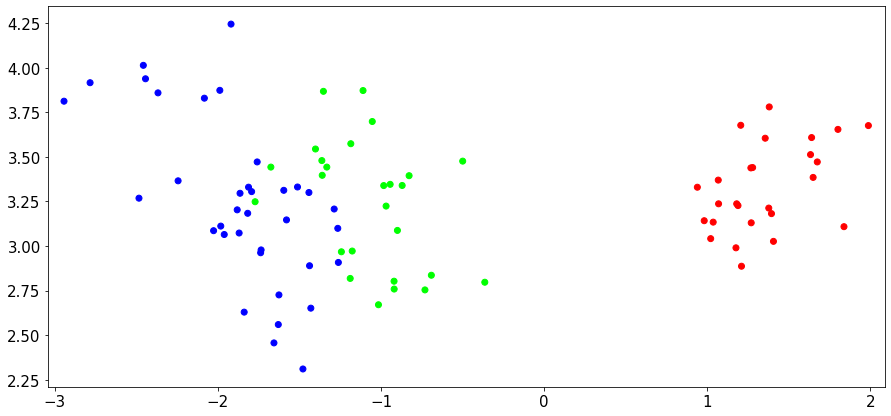

In [78]:
def __visualizeLabels(features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    y = referenceLabels

    plt.scatter(features[:, 0], features[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(features[:, 0].min() - 0.1, features[:, 0].max() + 0.1)
    plt.ylim(features[:, 1].min() - 0.1, features[:, 1].max() + 0.1)
    plt.show()
    t = 0
    
__visualizeLabels(trainingFeatures2D, trainingLabels)

### k-NN implementation

Implement k-NN for prediction of iris labels. Test k-NN for different k-s and find the best one in the space of {1, 2, 3, 4, 5}. Use validation set for testing different k values.

Please note that it is NOT allowed to use KNeighborsClassifier or other existing implementation of k-NN. We expect that can implement it yourself.


In [79]:
# Calculates the euclidean distance between two points.
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def __kNNTest(trainingFeatures2D, trainingLabels, n_neighbors, validationFeatures2D, validationLabels):
    # make a counter to count how many times we find the correct label
    count = 0

    # Iterates the length of validationFeatures2D array
    for i in range(np.size(validationFeatures2D,0)):
        # Creates an empty distance array for each new iteration in the validationFeatures2D array
        dist_arr = np.empty(np.size(trainingFeatures2D,0))

        # Iterates the length of trainingFeatures2D array
        for j in range(np.size(trainingFeatures2D,0)):
            # Calculates the distance using the np.linalg.norm
            dist = np.linalg.norm(validationFeatures2D[i] - trainingFeatures2D[j])
            # inserts the calculated distances into the dist_arr
            dist_arr[j] = dist
        # Creates label array, that is sorted using argsort which sort an
        # array returning the indices that holds the lowest value (distance in this case)
        label_arr = dist_arr.argsort()

        # Create new variables to calulate the number of occurences of a specific label
        zero = 0
        one = 0
        two = 0
        pred_label = trainingLabels[label_arr[0]]

        # Check what labels we find in the label array
        for x in range (n_neighbors):
            if trainingLabels[label_arr[x]] == 0:
                zero = zero + 1
            elif trainingLabels[label_arr[x]] == 1:
                one = one + 1
            elif trainingLabels[label_arr[x]] == 2:
                two = two + 1
        # Insert the value into the predicted label array
        if zero > one and zero > two:
             pred_label = 0
        elif one > zero and one > two:
            pred_label = 1
        elif two > zero and two > one:
            pred_label = 2

        # Check if the prediction we made is corrosponding to the one in the validation array
        # if correct, increase the counter by one
        if pred_label == validationLabels[i]:
            count = count + 1

    # calucate the final count of corret labels in order to return it as a float (reprecenting accuracy in %)
    accuracy = count / len(validationFeatures2D)
    return accuracy

for n in range(1, 6):
    print('accuracy = ', __kNNTest(trainingFeatures2D, trainingLabels, n, validationFeatures2D, validationLabels))


accuracy =  0.9655172413793104
accuracy =  0.9655172413793104
accuracy =  1.0
accuracy =  1.0
accuracy =  1.0


### Random forests implementation

Implement random forest for prediciton of iris labels. Select any reasonable configuration of parameters for the random forest predictor

Here you are allowed to use existing implementations, please check RandomForestClassifier from sklearn

In [80]:
def __randomForests(trainingFeatures2D, trainingLabels):
    model = RandomForestClassifier(n_estimators=200, criterion='gini')
    predictor = model.fit(trainingFeatures2D, trainingLabels)

    return predictor

predictor = __randomForests(trainingFeatures2D, trainingLabels)

### Visualizing predictor boundaries

Modify function __visualizeLabels to visualize not only labels but also decision boundaries of a predictor. Apply kNN classifier with optimal k on testing features and visualize the obtained results. Visualize the obtained results in comparion with the true testing labels. Apply random forest classifier on testing features and visualize the obtained results.

Here, you are allowed to use KNeighborsClassifier in __kNN.

Hint: check this example https://stackoverflow.com/questions/41138706/recreating-decision-boundary-plot-in-python-with-scikit-learn-and-matplotlib

In [81]:
def __visualizePredictions(predictor, features, referenceLabels):
    plt.figure()
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    h = 0.05
    y = referenceLabels
    #---put your code here
    #--- it is expexted that you get xx and yy as coordinates for visualization, and Z as labels for area visualization
    plt.pcolormesh(xx, yy, Z, cmap = cmap_light)
    # Plot also the training points
    plt.scatter(features[:, 0], features[:, 1], c = y, cmap = cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


#k = ??
kNNPredictor = __kNN(trainingFeatures2D, trainingLabels, k)
RFPredictor  = __randomForests(trainingFeatures2D, trainingLabels)
__visualizePredictions(kNNPredictor, testingFeatures2D, testingLabels)
__visualizePredictions(RFPredictor, testingFeatures2D, testingLabels)

NameError: name '__kNN' is not defined